In [1]:
import pyabf
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob 
from ephys_functions import detect_peaks, count_peaks_selected_sweeps, count_peaks, plot_by_genotype, plot_by_genotype_figure


In [ ]:
def process_last10_and_plot(csv_file_path, output_dir="C:\\Users\\rbondare\\ephys\\results\\"):
    # Load metadata
    file_info = pd.read_excel(csv_file_path)
    # Remove rows with missing files
    file_info = file_info[file_info['filepath'].apply(os.path.exists)]
    if file_info.empty:
        print("No valid files found.")
        return

    # Remove previous results file if exists 
    results_csv = os.path.join(output_dir, "selected_10sweeps_peak_results.xlsx")
    if os.path.exists(results_csv):
        os.remove(results_csv)

    # Count peaks for each file (last 10 sweeps)
    for i, (_, row) in enumerate(file_info.iterrows()):
        print(f"Processing file {i+1}/{len(file_info)}: {row['filepath']}")
        count_peaks_selected_sweeps(
            abf_file=row['filepath'],
            condition=row['condition'],
            genotype=row['genotype'],
            ID=row['ID'],
            comment=row['comment'],
            time_window=(0.5, 0.515),
            peak_params=None,
            output_dir=output_dir
        )
    
    # Process results AFTER all files are done (unindent these lines)
    results_df = pd.read_excel(results_csv)
    print("Columns in results_df:", results_df.columns.tolist())
    print(results_df.head())
    # Exclude rows where comment is "exclude"
    filtered_df = results_df[results_df['comment'].str.strip().str.lower() != "exclude"]
    print("number of cells after filtering:", len(filtered_df))
    pivot = filtered_df.pivot_table(
        index=['ID', 'genotype'],
        columns='condition',
        values='normalized_peaks'
    ).reset_index()

    plot_by_genotype(pivot)

In [ ]:
def process_last10_and_add(csv_file_path):
    # Load the existing results file
    results_df = pd.read_excel(csv_file_path)
    
    # Add new column for selected 10 sweeps if it doesn't exist
    if 'selected_10sweeps' not in results_df.columns:
        results_df['selected_10sweeps'] = None
    
    # Helper function to calculate normalized peaks for last 10 sweeps
    def calculate_last10_peaks(abf_file, time_window=None, peak_params=None):
        if peak_params is None:
            peak_params = {
                'height_threshold': 0,
                'prominence_min': 0.1,
                'distance_min': 3
            }
        
        try:
            abf = pyabf.ABF(abf_file)
            total_peaks = 0
            
            # Only use the last 10 sweeps (or all if fewer than 10)
            sweep_indices = abf.sweepList[-10:] if len(abf.sweepList) > 10 else abf.sweepList
            total_sweeps = len(sweep_indices)
            total_firing_rate = 0
            
            for sweep in sweep_indices:
                abf.setSweep(sweep)
                
                # Filter data by time window if specified
                if time_window is not None:
                    time_mask = (abf.sweepX >= time_window[0]) & (abf.sweepX <= time_window[1])
                    sweep_data = abf.sweepY[time_mask]
                    # Count peaks in the window
                    peaks, _ = detect_peaks(sweep_data, **peak_params)
                    total_peaks += len(peaks)
                else:
                    sweep_data = abf.sweepY
                    sweep_duration = abf.sweepX[-1] - abf.sweepX[0]
                    # Count peaks in the whole sweep and calculate firing rate
                    peaks, _ = detect_peaks(sweep_data, **peak_params)
                    firing_rate = len(peaks) / sweep_duration if sweep_duration > 0 else 0
                    total_firing_rate += firing_rate

            if time_window is not None:
                # Normalized peaks: total peaks divided by number of sweeps
                normalized_peaks = total_peaks / total_sweeps if total_sweeps > 0 else 0
                return normalized_peaks
            else:
                # Average firing rate
                average_firing_rate = total_firing_rate / total_sweeps if total_sweeps > 0 else 0
                return average_firing_rate

        except Exception as e:
            print(f"Error processing file {abf_file}: {e}")
            return None
    
    # Process each row to calculate peaks for last 10 sweeps
    for i, row in results_df.iterrows():
        if pd.notna(row['filepath']) and os.path.exists(row['filepath']):
            print(f"Processing file {i+1}/{len(results_df)}: {row['filepath']}")
            
            # Calculate normalized peak count for last 10 sweeps
            peak_count = calculate_last10_peaks(
                abf_file=row['filepath'],
                time_window=None,
                peak_params=None
            )
            
            # Update the specific row
            results_df.at[i, 'selected_10sweeps'] = peak_count
        else:
            # Handle missing files
            results_df.at[i, 'selected_10sweeps'] = None
            print(f"File not found: {row.get('filepath', 'N/A')}")
    
    # Save back to the same file
    results_df.to_excel(csv_file_path, index=False)
    print(f"Updated Excel file saved with new 'selected_10sweeps' column")
    
    # Filter and plot
    filtered_df = results_df[results_df['comment'].str.strip().str.lower() != "exclude"]
    print(f"Number of cells after filtering: {len(filtered_df)}")
    # Find IDs in filtered_df that are not in pivot
    missing_ids = set(filtered_df['ID']) - set(results_df['ID'])
    if missing_ids:
        print("IDs not plotted:", sorted(missing_ids))
    else:
        print("All filtered cells are plotted.")


process_last10_and_add("C:\\Users\\rbondare\\ephys\\results\\all_peak_results_final.xlsx")

Processing file 1/92: Z:\Group Members\Rima\Ephys_NE\DATA\gad\24.03.2025 M1\2025_03_24_0002.abf
Processing file 2/92: Z:\Group Members\Rima\Ephys_NE\DATA\gad\24.03.2025 M1\2025_03_24_0003.abf
Processing file 3/92: Z:\Group Members\Rima\Ephys_NE\DATA\gad\24.03.2025 M1\2025_03_24_0004.abf
Processing file 4/92: Z:\Group Members\Rima\Ephys_NE\DATA\gad\24.03.2025 M1\2025_03_24_0007.abf
Processing file 5/92: Z:\Group Members\Rima\Ephys_NE\DATA\gad\24.03.2025 M1\2025_03_24_0008.abf
Processing file 6/92: Z:\Group Members\Rima\Ephys_NE\DATA\gad\24.03.2025 M1\2025_03_24_0009.abf
Processing file 7/92: Z:\Group Members\Rima\Ephys_NE\DATA\gad\24.03.2025 M1\2025_03_24_0012.abf
Processing file 8/92: Z:\Group Members\Rima\Ephys_NE\DATA\gad\24.03.2025 M1\2025_03_24_0013.abf
Processing file 9/92: Z:\Group Members\Rima\Ephys_NE\DATA\gad\24.03.2025 M1\2025_03_24_0014.abf
Processing file 10/92: Z:\Group Members\Rima\Ephys_NE\DATA\gad\25.03.2025 M2\2025_03_25_0004.abf
Processing file 11/92: Z:\Group Members

checking that excel tables are read correctly


In [ ]:
import os
import pandas as pd
file_info = pd.read_excel("C:\\Users\\rbondare\\ephys\\metadata\\ephys_all_data.xlsx")
file_info['filepath'] = file_info['filepath'].str.strip()  # Remove whitespace
print(file_info['filepath'].tolist())  # Debug: print all file paths
file_info = file_info[file_info['filepath'].apply(os.path.exists)]


['Z:\\Group Members\\Rima\\Ephys_NE\\DATA\\gad\\24.03.2025 M1\\2025_03_24_0002.abf', 'Z:\\Group Members\\Rima\\Ephys_NE\\DATA\\gad\\24.03.2025 M1\\2025_03_24_0003.abf', 'Z:\\Group Members\\Rima\\Ephys_NE\\DATA\\gad\\24.03.2025 M1\\2025_03_24_0004.abf', 'Z:\\Group Members\\Rima\\Ephys_NE\\DATA\\gad\\24.03.2025 M1\\2025_03_24_0007.abf', 'Z:\\Group Members\\Rima\\Ephys_NE\\DATA\\gad\\24.03.2025 M1\\2025_03_24_0008.abf', 'Z:\\Group Members\\Rima\\Ephys_NE\\DATA\\gad\\24.03.2025 M1\\2025_03_24_0009.abf', 'Z:\\Group Members\\Rima\\Ephys_NE\\DATA\\gad\\24.03.2025 M1\\2025_03_24_0012.abf', 'Z:\\Group Members\\Rima\\Ephys_NE\\DATA\\gad\\24.03.2025 M1\\2025_03_24_0013.abf', 'Z:\\Group Members\\Rima\\Ephys_NE\\DATA\\gad\\24.03.2025 M1\\2025_03_24_0014.abf', 'Z:\\Group Members\\Rima\\Ephys_NE\\DATA\\gad\\25.03.2025 M2\\2025_03_25_0004.abf', 'Z:\\Group Members\\Rima\\Ephys_NE\\DATA\\gad\\25.03.2025 M2\\2025_03_25_0007.abf', 'Z:\\Group Members\\Rima\\Ephys_NE\\DATA\\gad\\25.03.2025 M2\\2025_03_25_00

Generate plots using ephys_functions from an already made csv file

Columns in results_df: ['filepath', 'filename', 'condition', 'genotype', 'ID', 'total_sweeps', 'normalized_first_peak', 'selected_10sweeps_first', 'normalized_all_peaks', 'selected_10sweeps_all', 'firingRate_10sweeps_all', 'comment']
                                            filepath             filename  \
0  Z:\Group Members\Rima\Ephys_NE\DATA\gad\24.03....  2025_03_24_0002.abf   
1  Z:\Group Members\Rima\Ephys_NE\DATA\gad\24.03....  2025_03_24_0003.abf   
2  Z:\Group Members\Rima\Ephys_NE\DATA\gad\24.03....  2025_03_24_0004.abf   
3  Z:\Group Members\Rima\Ephys_NE\DATA\gad\24.03....  2025_03_24_0007.abf   
4  Z:\Group Members\Rima\Ephys_NE\DATA\gad\24.03....  2025_03_24_0008.abf   

       condition    genotype  ID  total_sweeps  normalized_first_peak  \
0       baseline  eGFP-Gad67   1            18                    1.0   
1  Noradrenaline  eGFP-Gad67   1            32                    1.0   
2           wash  eGFP-Gad67   1            42                    1.0   
3       bas

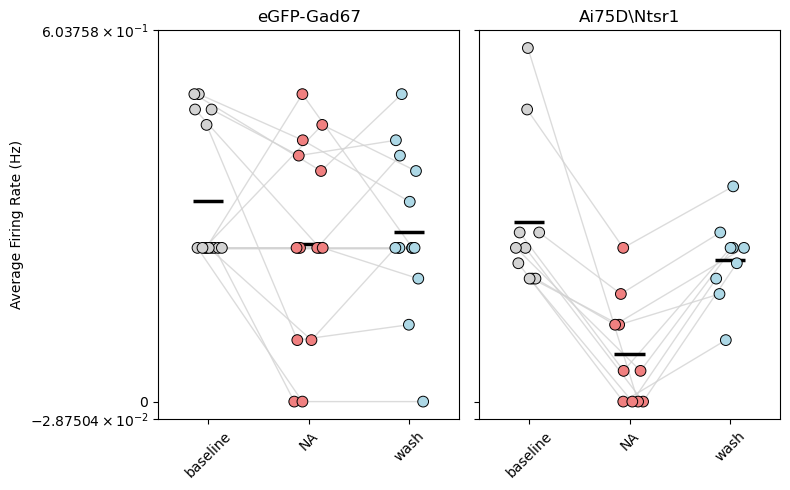

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_genotypes_comparison(results):
    """
    Plot two genotypes side by side with shared y-axis for easy comparison
    """
    genotypes = results['genotype'].unique()
    conditions = ['baseline', 'Noradrenaline', 'wash']
    colors = ['lightgrey', 'lightcoral', 'lightblue']
    
    fig, axes = plt.subplots(1, len(genotypes), figsize=(8, 5), sharey=True)
    
    for idx, genotype in enumerate(genotypes):
        ax = axes[idx] if len(genotypes) > 1 else axes
        group = results[results['genotype'] == genotype]
        
        if group.empty:
            continue
        
        # Create jittered x positions
        jitter_amount = 0.15
        np.random.seed(42)
        
        # Plot each cell as a line across conditions
        for _, row in group.iterrows():
            y = [row[cond] for cond in conditions]
            x_jittered = [i + np.random.uniform(-jitter_amount, jitter_amount) for i in range(len(conditions))]
            
            ax.plot(x_jittered, y, color='lightgray', alpha=0.8, linewidth=1)
            ax.scatter(x_jittered, y, color=colors, s=60, zorder=3, edgecolors='black', linewidths=0.7)
        
        # Plot means
        for i, cond in enumerate(conditions):
            y_vals = group[cond].dropna().values
            if len(y_vals) > 0:
                ax.hlines(np.mean(y_vals), i - 0.15, i + 0.15, color='black', linewidth=2.5)
        
        ax.set_xticks(range(len(conditions)))
        ax.set_xticklabels(['baseline', 'NA', 'wash'], rotation=45)
        ax.set_title(f"{genotype}", fontsize=12)
        ax.set_xlim(-0.5, len(conditions) - 0.5)
        ax.set_yscale('symlog')
    
    # Set y-label only on the leftmost plot
    axes[0].set_ylabel("Average Firing Rate (Hz)")
    plt.tight_layout()
    plt.show()
results_csv = "C:\\Users\\rbondare\\ephys\\results\\all_peak_results_final.xlsx"
results_df = pd.read_excel(results_csv)
print("Columns in results_df:", results_df.columns.tolist())
print(results_df.head())
# Exclude rows where comment is "exclude"
filtered_df = results_df[results_df['comment'].str.strip().str.lower() != "exclude"]
print("number of cells after filtering:", len(filtered_df))

pivot = filtered_df.pivot_table(
    index=['ID', 'genotype'],
    columns='condition',
    values='firingRate_10sweeps_all'


).reset_index()
plot_genotypes_comparison(pivot)

number of cells after filtering: 84

Repeated-measures ANOVA for genotype eGFP-Gad67:
                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
condition  0.9934 2.0000 34.0000 0.3808

  Post-hoc (Bonferroni corrected):
    Noradrenaline vs baseline: p = 0.9104
    Noradrenaline vs wash: p = 1.0000
    baseline vs wash: p = 0.9413


c:\Users\rbondare\AppData\Local\miniforge3\envs\ephys\Lib\site-packages\pingouin\pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


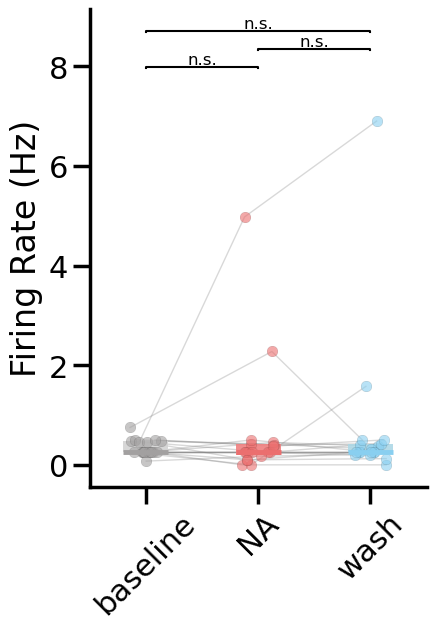


Repeated-measures ANOVA for genotype Ai75D\Ntsr1:
                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
condition     nan 2.0000 18.0000    nan

  Post-hoc (Bonferroni corrected):
    Noradrenaline vs baseline: p = 0.0002
    Noradrenaline vs wash: p = 0.0004
    baseline vs wash: p = 0.4642


c:\Users\rbondare\AppData\Local\miniforge3\envs\ephys\Lib\site-packages\pingouin\pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


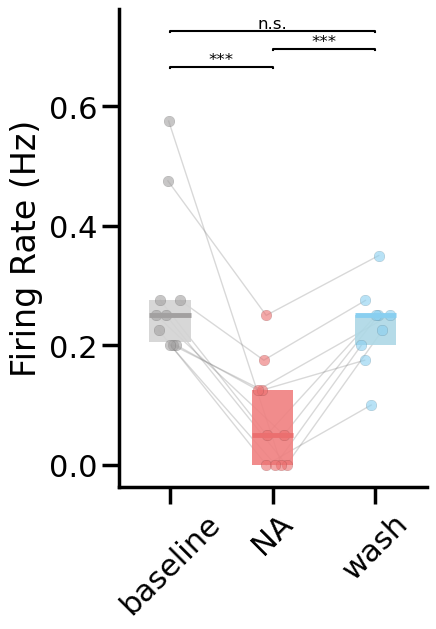

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from ephys_functions import plot_by_genotype_stat
import seaborn as sns
sns.set_context('poster')

results_csv = "C:\\Users\\rbondare\\ephys\\results\\all_peak_results_final.xlsx"
results_df = pd.read_excel(results_csv)
#print("Columns in results_df:", results_df.columns.tolist())
#print(results_df.head())
# Exclude rows where comment is "exclude"
filtered_df = results_df[results_df['comment'].str.strip().str.lower() != "exclude"]
print("number of cells after filtering:", len(filtered_df))

pivot = filtered_df.pivot_table(
    index=['ID', 'genotype'],
    columns='condition',
    values='firingRate_10sweeps_all'
).reset_index()

plot_by_genotype_stat(pivot, output_dir="C:\\Users\\rbondare\\ephys\\results\\")